# Correlation Plots
This code can be used to:
1) Generate correlation plots between all passive and active features (or your own features!)
2) Compare all of these features across two groups of interest
3) Fit a simple logistic regression model to predict which group participants belong to based on all features


******
There is some information that you must gather beforehand in order to run this code.

### Passive features
Since passive data features can take a long time to run based on how much data you have, these features should be generated and placed into PASSIVE_DIR. Features should be stored as .pkl files and named particpantId_featureName.pkl.

### Survey scores
Surveys will be scored based on the survey_scores function in cortex. The results will be saved, by participant and by category in files called participantID_category.csv in SURVEY_DIR. Thus, you must provide a scoring json file that can be used. We have provided an example file called example_scoring.json. The path to your scoring json file should be the value of SCORING_JSON. 

### Other features
It is likely that you may want to add some features that are neither passive data nor survey scores. These are grouped into two types:
1) Other global features
    - Other global features are "global" meaning they are valid across all time. Something like total number of activities or age may be a global feature. These features should be stored in a csv file called participantId_other_global_features.csv where each column of the dataframe is a differnet global feature. Each column that you would like to be used in analysis should be listed in the list OTHER_GLOBAL_FEATS. 
    - Other local features are "local" in time. These features look just like survey or passive data in that they will have a timestamp column (in ms) as well as columns for each feature. The file can be named anything, and the name of the file may or may not be in the columns. Using this filename, files will be saved in SURVEY_DIR as participantID_filename.csv. OTHER_LOCAL_FEATS should be a list of all of these file names. Then you must specify which columns in each file that should be usef in analysis. An example of how to do this in OTHER_LOCAL_SUBFEATS is shown below.
   - These files should be saved in the SURVEY_DIR directory.

### Improvement csv
The improvement csv is a csv with three columns, "part_id", "improved" and "change". The part_id column should always hold a list of all of the participant ids in the study. Improved is a binary variable for whether or not the participant improved (on whatever metric is relevant) over the course of the study and "change" is the magnitude of the improvement. "change" is not required here. These will then be used to look for differences in the groups that improved vs. did not improve based on the above features. 

Although the original purpose of the improvement csv is to track improvement, it can also be used to compare across other features of interest. For example, perhaps you are interested in comparing undergraduate and graduate students. Improved = 1 could be undergraduate, and improved = 0 could be graduate. 


In [3]:
import os
import sys
import json
import datetime
import LAMP
import numpy as np
import pandas as pd
LAMP.connect()

from cortex.utils.useful_functions import generate_ids, shift_time
from cortex.visualizations.correlation_functions import save_surveys_to_file, get_avg_var_data, get_corr, make_corr_plot

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, pearsonr

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.linear_model import LassoCV, ElasticNetCV, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
rng = np.random.RandomState(0)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans

In [2]:
# Example parameters -- fill in your own
SURVEY_DIR = "" # Path to a folder to hold the survey data
PASSIVE_DIR = "" # Path to a folder holding passive data
RESEARCHER_ID = ""
SCORING_JSON = "" # Path to a json file with a scoring dictionary
IMPROVEMENT_CSV = "" # csv with two groups to compare
PASSIVE_FEATS = ["entropy", "hometime"] # example list of passive features
OTHER_GLOBAL_FEATS = []
OTHER_LOCAL_FEATS = ["psqi_components", "dwai"] # example list of other local features
OTHER_LOCAL_SUBFEATS = {
    "psqi_components": ["component_1", "component_2"],
    "dwai": ["question_1", "question_2", "question_3"]
}

In [4]:
# Read JSON file
f = open(SCORING_JSON)
scoring_guide = json.load(f)
f.close()

In [5]:
# Colors for legend
passive_color = "lightgray"
global_other_color = "teal"
local_other_color = "deeppink"
survey_colors = [# survey
                 "mediumblue", "darkorange", "blueviolet",
                 "turquoise", "firebrick", "gold",
                 "forestgreen", "violet",  "lime",
                 "lightskyblue",]

def make_legend(feat_list):
    legend_elements = []
    all_survey_keys = [k for k in scoring_guide["questions"].keys()
                       if "map_to" not in scoring_guide["questions"][k]] + scoring_guide["category_list"]
    all_other_local_keys = []
    for x in OTHER_LOCAL_FEATS:
        all_other_local_keys += [x]
        all_other_local_keys += [y for y in OTHER_LOCAL_SUBFEATS[x]]
    for i, f in enumerate(feat_list):
        if f in PASSIVE_FEATS:
            legend_elements.append(Patch(facecolor=passive_color, label=str(i) + ": " + f))
        elif f in all_other_local_keys:
            legend_elements.append(Patch(facecolor=local_other_color, label=str(i) + ": " + f))
        elif f in OTHER_GLOBAL_FEATS:
            legend_elements.append(Patch(facecolor=global_other_color, label=str(i) + ": " + f))
        elif f in all_survey_keys:
            if len(scoring_guide["category_list"]) > len(survey_colors):
                legend_elements.append(Patch(facecolor=survey_colors[0], label=str(i) + ": " + f))
            else:
                if f in scoring_guide["category_list"]:
                    legend_elements.append(Patch(facecolor=survey_colors[scoring_guide["category_list"].index(f)],
                                                 label=str(i) + ": " + f))
                else:
                    group = scoring_guide["questions"][f]["category"]
                    legend_elements.append(Patch(facecolor=survey_colors[scoring_guide["category_list"].index(group)],
                                                 label=str(i) + ": " + f))
        else:
            print(f)
    return legend_elements

In [6]:
parts = generate_ids(RESEARCHER_ID)

# Score surveys and save output into SURVEY_DIR

In [7]:
# Get surveys for all participants
for p in parts:
    save_surveys_to_file(p, SURVEY_DIR, scoring_guide)

print("Done scoring surveys.")

[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_scores"...
[INFO:feature_types:_wrapper2] Processing primary feature "cortex.survey_sco

Done scoring surveys.


# Correlation plot for the average of each feature over time

In [7]:
avg_df = get_avg_var_data(parts, scoring_guide, OTHER_GLOBAL_FEATS, OTHER_LOCAL_FEATS, OTHER_LOCAL_SUBFEATS,
                     PASSIVE_FEATS, SURVEY_DIR, PASSIVE_DIR, avg = 1)

[DEBUG:colorbar:_get_ticker_locator_formatter] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1483727610>
[DEBUG:colorbar:update_ticks] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1483727610> on colorbar
[DEBUG:colorbar:_add_solids_pcolormesh] Setting pcolormesh
[DEBUG:font_manager:_findfont_cached] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[DEBUG:font_manager:_findfont_cached] findfont: score(<Font 'cmr10' (cmr10.ttf) normal normal 400 normal>) = 10.05
[DEBUG:font_manager:_findfont_cached] findfont: score(<Font 'DejaVu Sans' (DejaVuSans.ttf) normal normal 400 normal>) = 0.05
[DEBUG:font_manager:_findfont_cached] findfont: score(<Font 'cmtt10' (cmtt10.ttf) normal normal 400 normal>) = 10.05
[DEBUG:font_manager:_findfont_cached] findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
[DEBUG:font_manager:_findfont_cached] findfont: sc

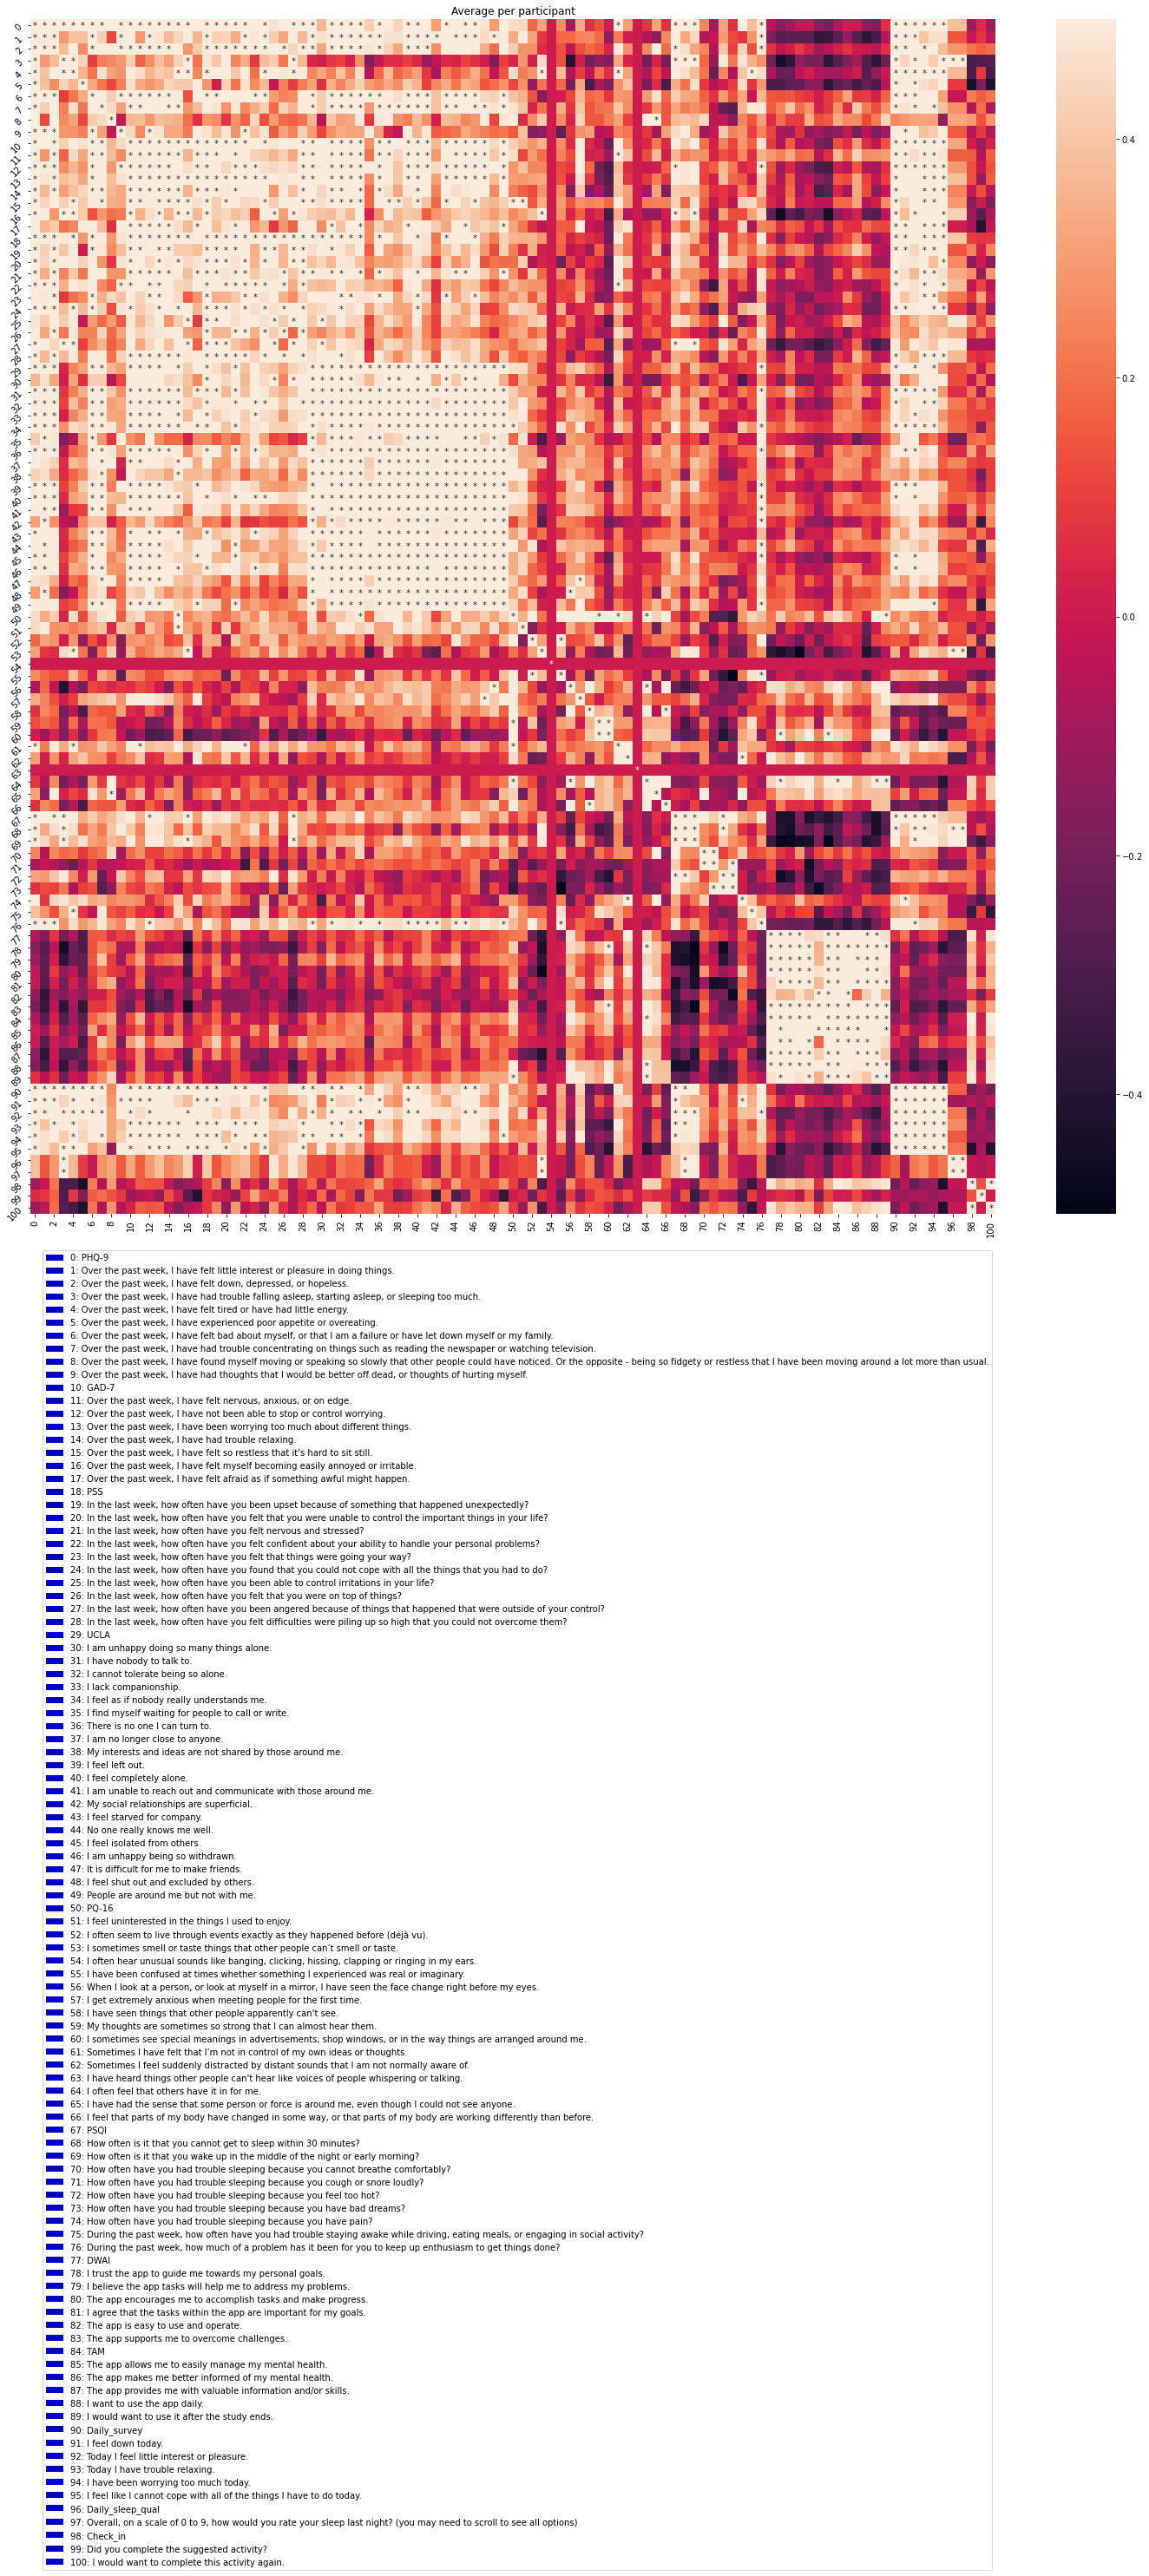

In [9]:
feat_list = [x for x in avg_df.keys() if x != "part_id"]
mat, pvals, dict_corr = get_corr(avg_df[feat_list], feat_list, feat_list,
                                 req_list=[], alpha=0.05, show_num=0)
fig = make_corr_plot(mat, pvals, feat_list, feat_list, title="Average per participant")

# Make legend
legend_elements = make_legend(feat_list)

lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(0.8, 0), prop={'size': 10})
plt.tight_layout()

# Correlation plot for the variance of each feature over time

In [10]:
var_df = get_avg_var_data(parts, scoring_guide, OTHER_GLOBAL_FEATS, OTHER_LOCAL_FEATS, OTHER_LOCAL_SUBFEATS,
                     PASSIVE_FEATS, SURVEY_DIR, PASSIVE_DIR, avg = 0)

[DEBUG:colorbar:_get_ticker_locator_formatter] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f14837ec7f0>
[DEBUG:colorbar:update_ticks] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f14837ec7f0> on colorbar
[DEBUG:colorbar:_add_solids_pcolormesh] Setting pcolormesh


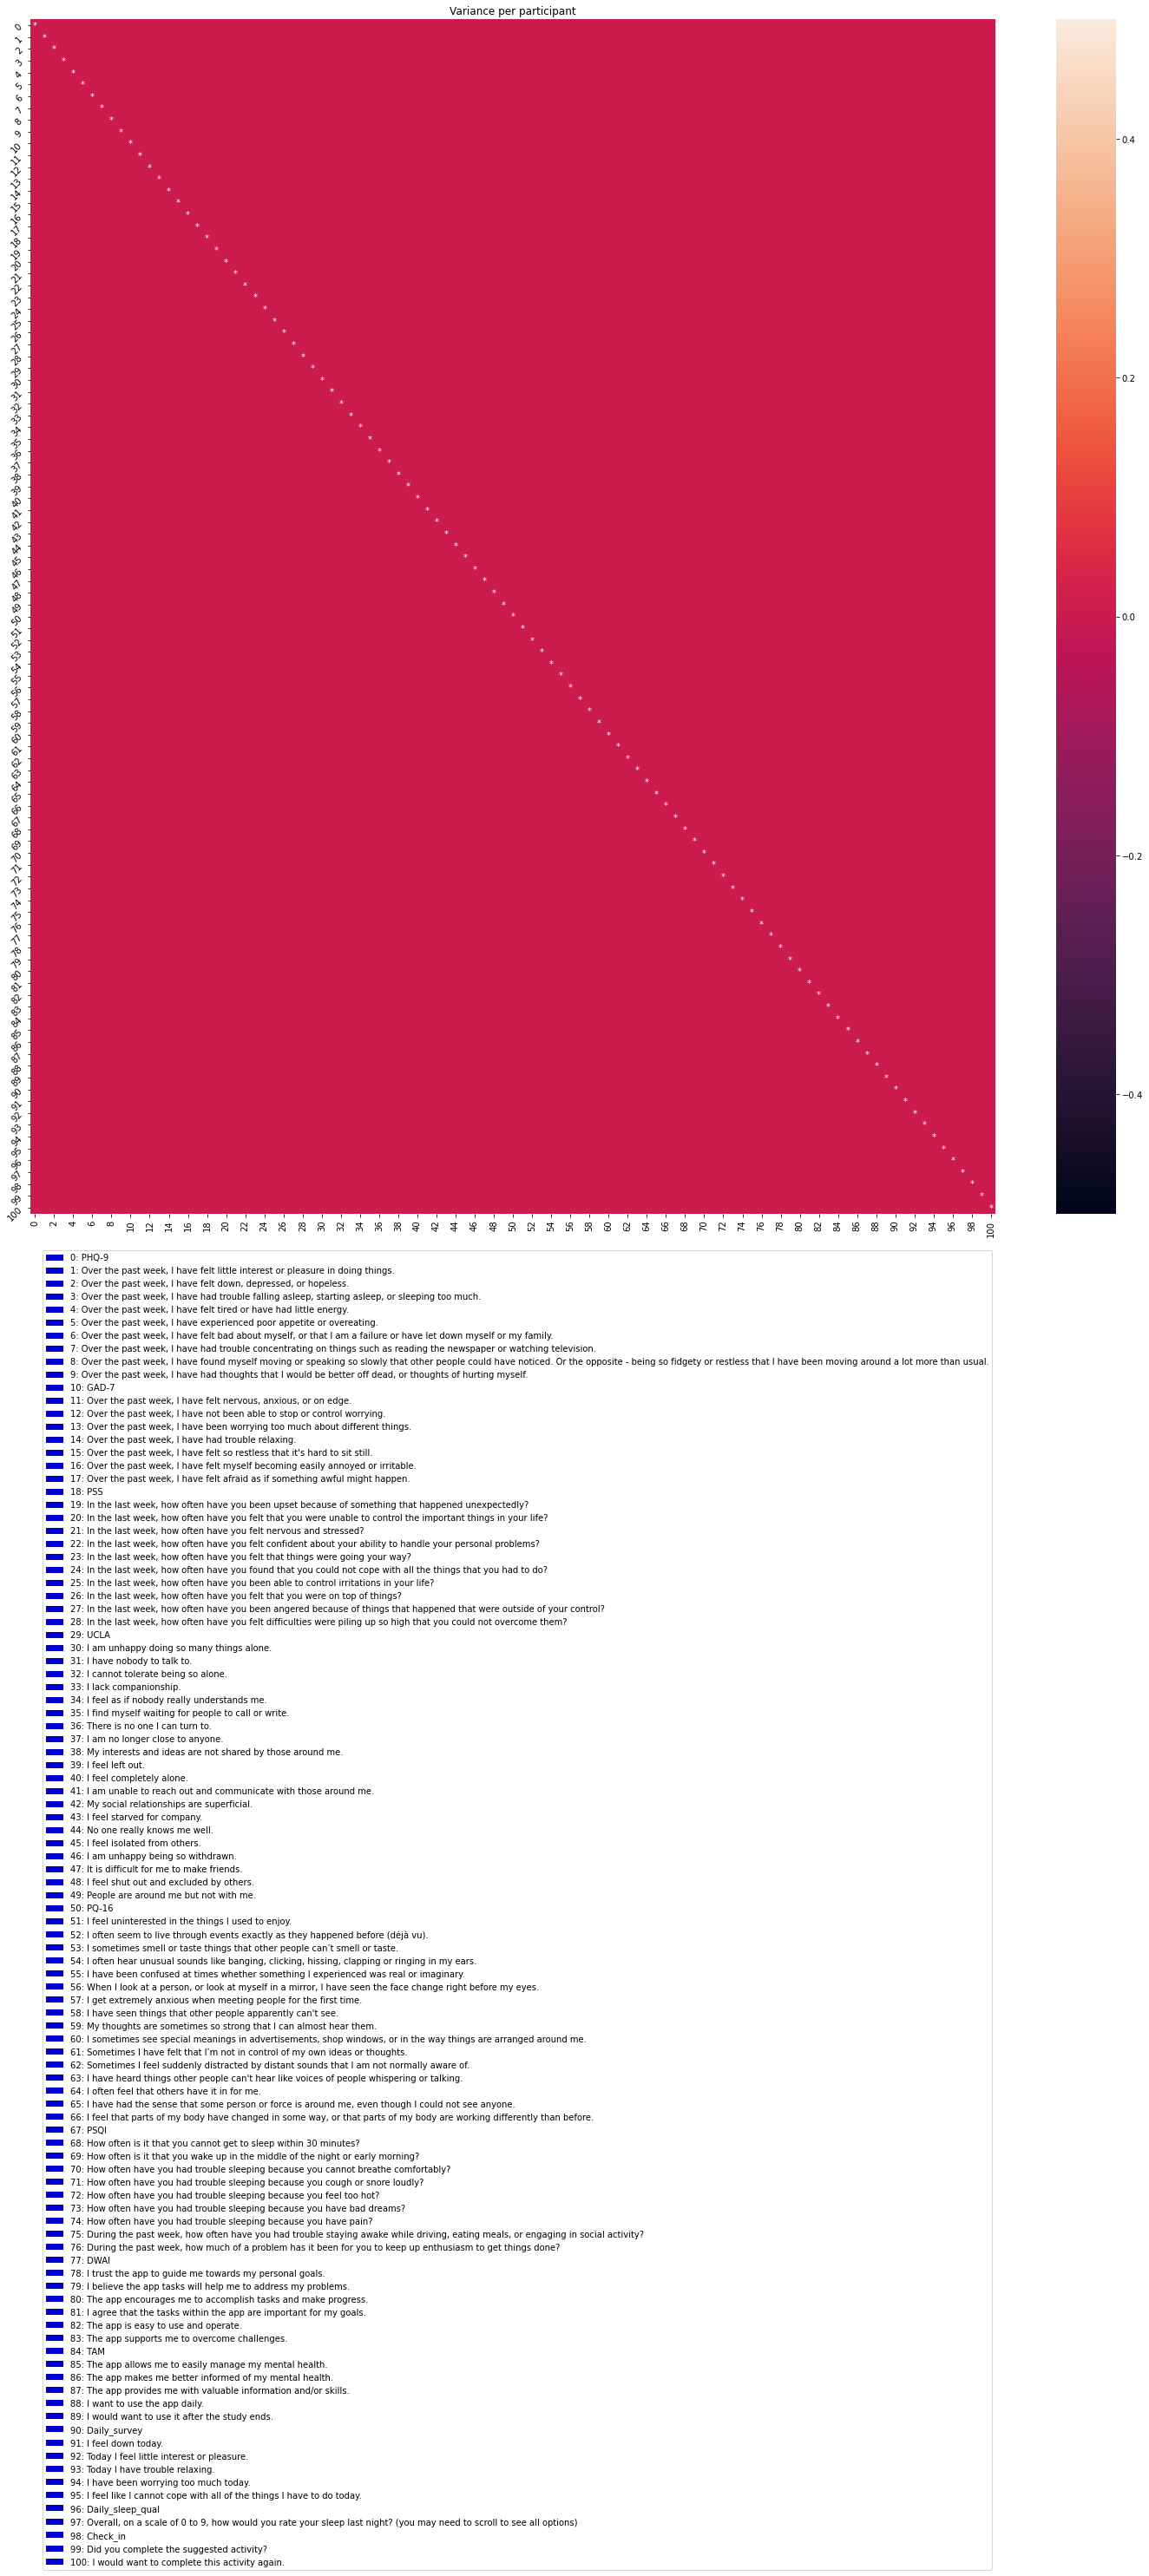

In [11]:
feat_list = [x for x in var_df.keys() if x != "part_id"]
mat, pvals, dict_corr = get_corr(var_df[feat_list], feat_list, feat_list,
                                 req_list=[], alpha=0.05, show_num=0)
fig = make_corr_plot(mat, pvals, feat_list, feat_list, title="Variance per participant")

# Make legend
legend_elements = make_legend(feat_list)

lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(0.8, 0), prop={'size': 10})
plt.tight_layout()

# Correlation for each feature in time

In [12]:
# Load in all data
# by time

all_survey_keys = []
for x in scoring_guide["category_list"]:
    all_survey_keys += [x]
    all_survey_keys += [k for k in scoring_guide["questions"].keys()
        if ("map_to" not in scoring_guide["questions"][k]) and
           (scoring_guide["questions"][k]["category"] == x)]
all_other_local_keys = []
for x in OTHER_LOCAL_FEATS:
    all_other_local_keys += [y for y in OTHER_LOCAL_SUBFEATS[x]]

feat_order = all_survey_keys + all_other_local_keys + PASSIVE_FEATS

big_df = None
for p in parts:
    dict0 = None
    for s in scoring_guide["category_list"]:
        survey_path = SURVEY_DIR + p + "_" + s + ".csv"
        if os.path.exists(survey_path):
            df = pd.read_csv(survey_path)
            df = df[[k for k in df.keys() if (k != "Unnamed: 0")]]
            if dict0 is None:
                dict0 = df
            else:
                dict0 = dict0.merge(df, how="outer", on="timestamp")
    for o in OTHER_LOCAL_FEATS:
        feat_path = SURVEY_DIR + p + "_" + o + ".csv"
        if os.path.exists(feat_path):
            df = pd.read_csv(feat_path)
            df = df[["timestamp"] + OTHER_LOCAL_SUBFEATS[o]]
            if dict0 is None:
                dict0 = df
            else:
                dict0 = dict0.merge(df, how="outer", on="timestamp")
    for s in PASSIVE_FEATS:
        feat_path = PASSIVE_DIR + p + "_" + s + ".pkl"
        if os.path.exists(feat_path):
            df = pd.read_pickle(feat_path)
            if "value" in df:
                df = df.rename(columns={"value": s})
            df = df[["timestamp", s]]
            df["timestamp"] = df["timestamp"].astype(np.int64) // 10**6
            df = df.rename(columns={"value": s})
            if dict0 is None:
                dict0 = df
            else:
                dict0 = dict0.merge(df, how="outer", on="timestamp")
    if dict0 is not None:
        dict0["part_id"] = [p] * len(dict0)
        if big_df is None:
            big_df = dict0
        else:
            big_df = pd.concat([big_df, dict0])
big_df = big_df.reset_index()
big_df = big_df[feat_order]
print("Done.")

Done.


[DEBUG:colorbar:_get_ticker_locator_formatter] locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1472a3c130>
[DEBUG:colorbar:update_ticks] Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f1472a3c130> on colorbar
[DEBUG:colorbar:_add_solids_pcolormesh] Setting pcolormesh


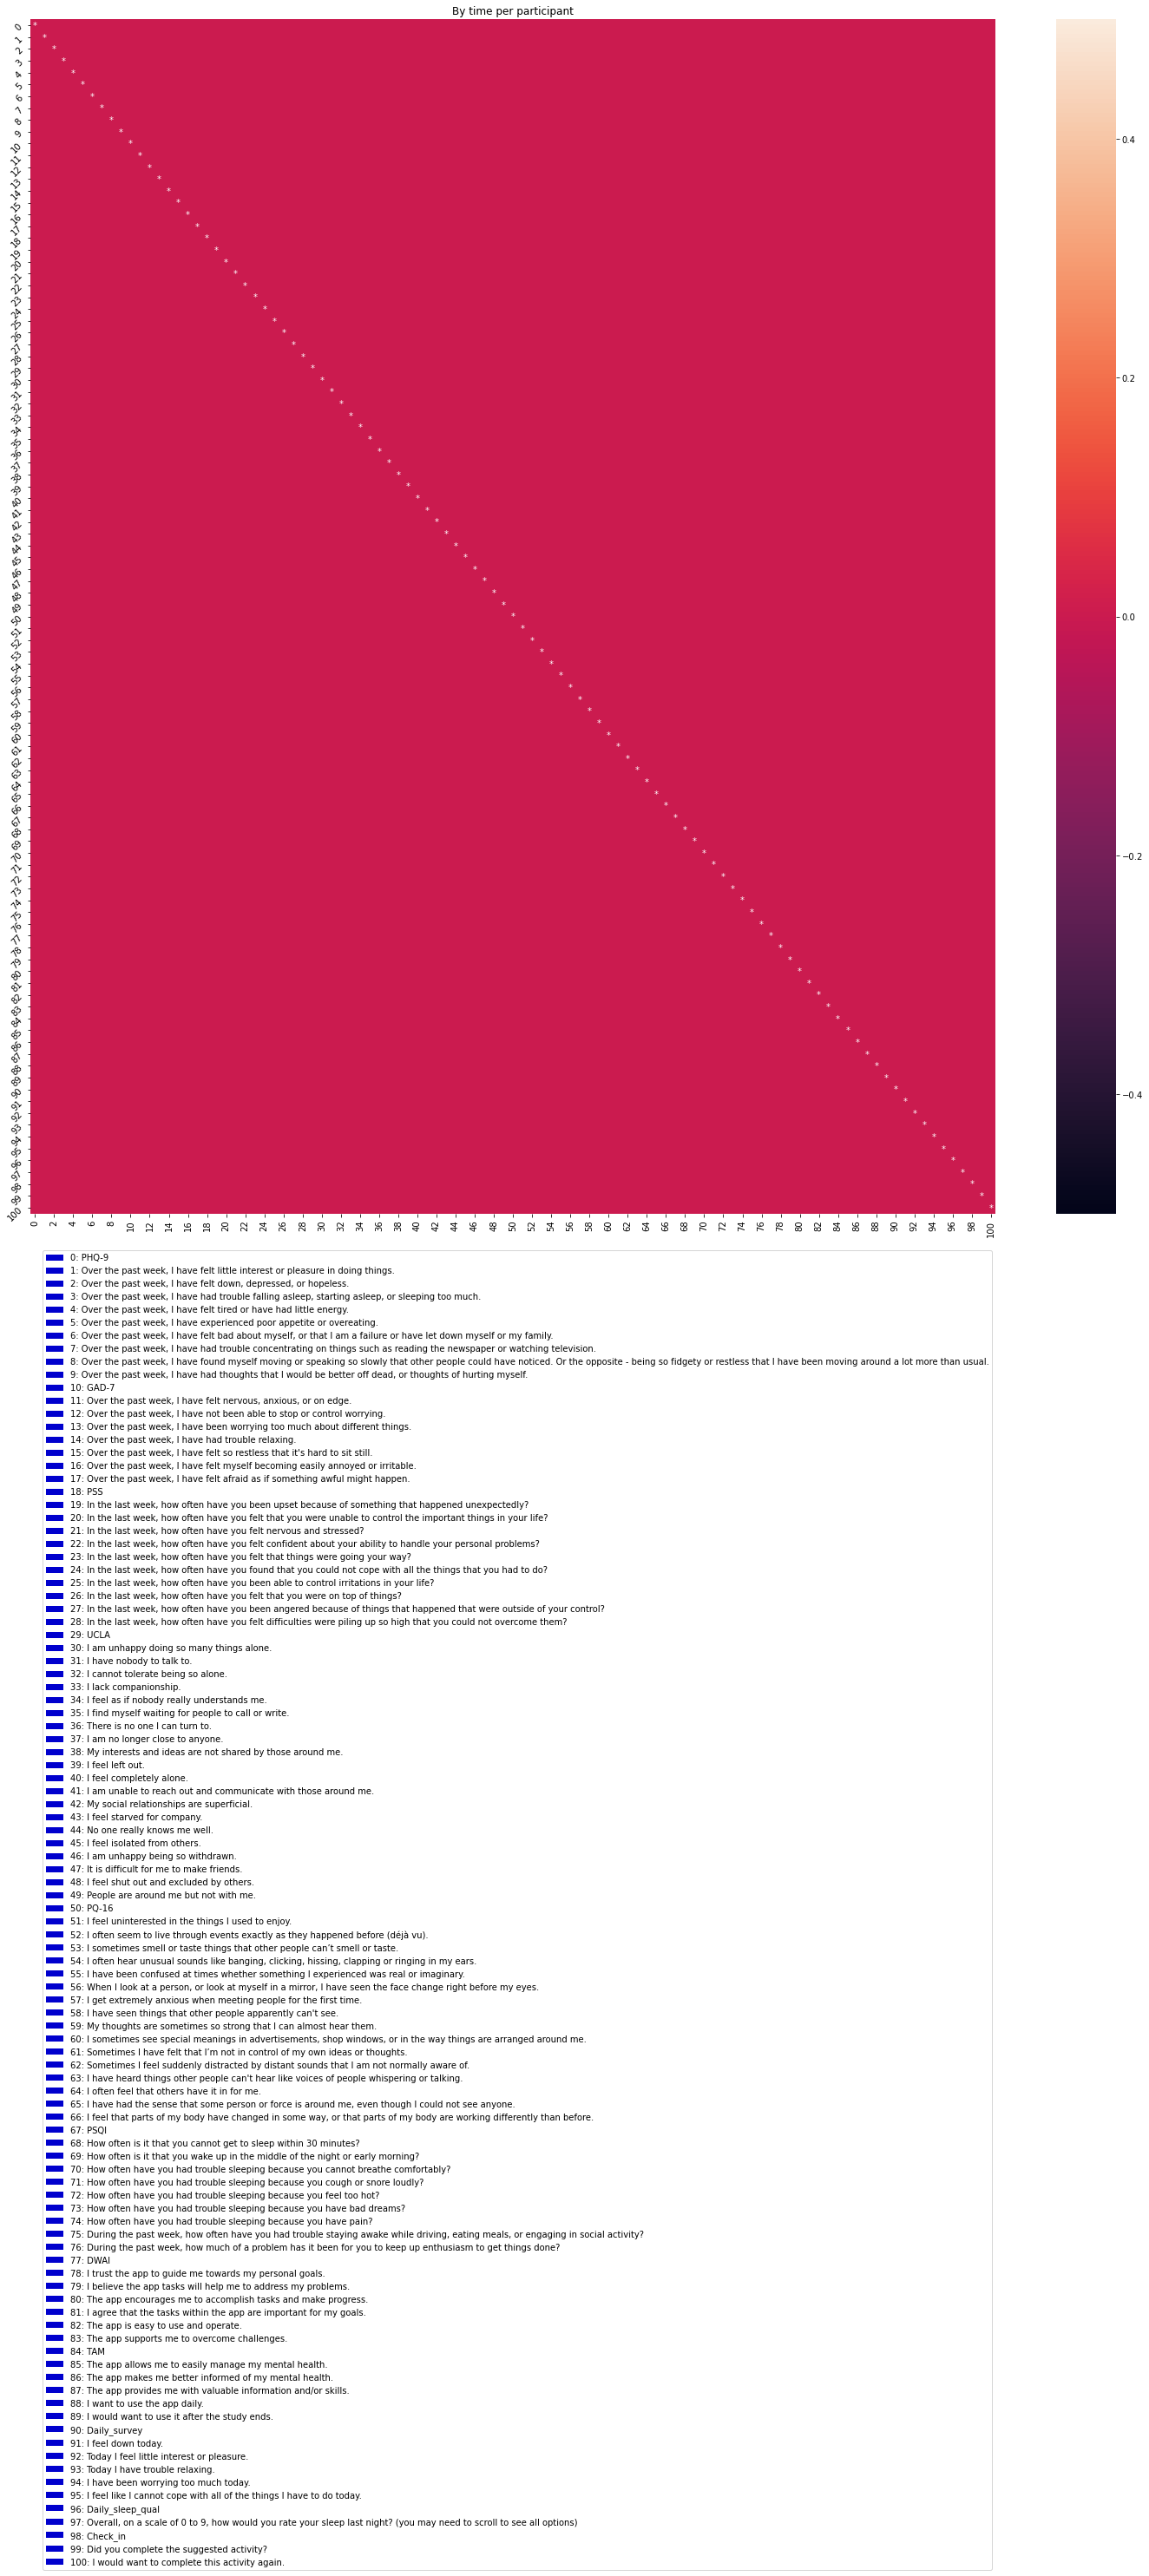

In [13]:
feat_list = [x for x in big_df.keys() if (x != "part_id") & (x != "timestamp") & (x != "index")]
mat, pvals, dict_corr = get_corr(big_df[feat_list], feat_list, feat_list,
                                 req_list=[], alpha=0.05, show_num=0)
fig = make_corr_plot(mat, pvals, feat_list, feat_list, title="By time per participant")

# Make legend
legend_elements = make_legend(feat_list)

lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(0.8, 0), prop={'size': 10})
plt.tight_layout()

# Comparison of each feature between the improved vs. did not improve group

In [16]:
diff_df = pd.read_csv(IMPROVEMENT_CSV)
diff_df = diff_df[[k for k in diff_df if k != "Unnamed: 0"]]

FileNotFoundError: [Errno 2] No such file or directory: ''

In [56]:
diff_df = diff_df.merge(avg_df, on="part_id")

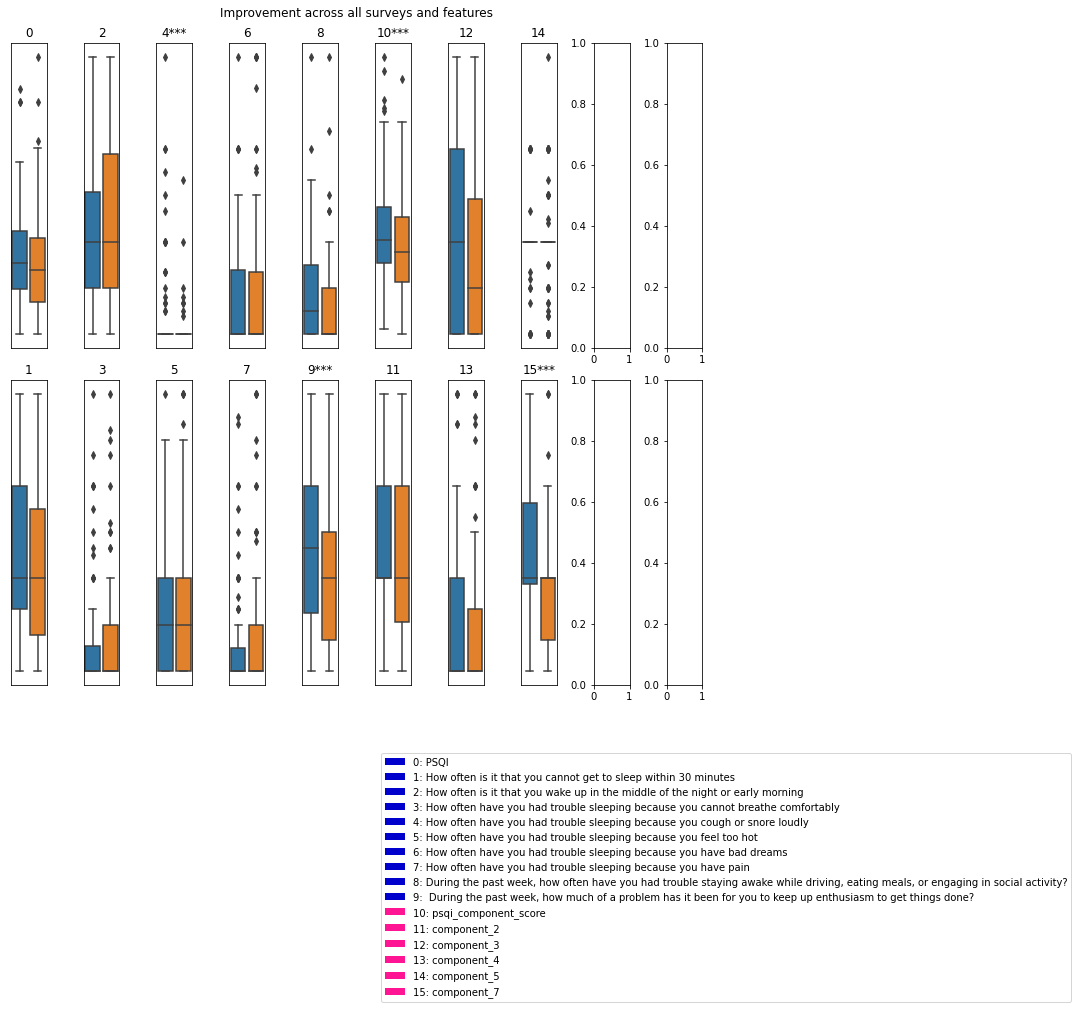

In [57]:
col_names = [k for k in diff_df.keys() if (k != "part_id") and
                                          (k != "improved") and
                                          (k != "change")]
if len(col_names) > 10:
    rows = int(len(col_names) / 10) + 1
    fig, axes = plt.subplots(rows, 10, figsize=(10,10))
else:
    rows = int(len(col_names) / 2) + 1
    fig, axes = plt.subplots(rows, 2, figsize=(10,10))
for i, k in enumerate(col_names):
    r = i % rows
    c = int(i / rows)
    axes[r,c] = sns.boxplot(ax=axes[r,c], y=k, x="improved", data=diff_df.dropna())
    curr_df = diff_df.dropna()
    curr_df = curr_df[[k, "improved"]]
    p_val = ttest_ind(curr_df[curr_df["improved"] == 0][k],
              curr_df[curr_df["improved"] == 1][k]).pvalue
    axes[r,c].set_xticks([])
    axes[r,c].set_ylabel("")
    axes[r,c].set_xlabel("")
    axes[r,c].set_yticks([])
    if p_val < 0.05:
        axes[r,c].set_title(str(i) + "***")
    else:
        axes[r,c].set_title(i)
plt.suptitle("Improvement across all surveys and features")

# Make legend
legend_elements = make_legend(feat_list)

lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(1.5, -0.05), prop={'size': 10})
plt.tight_layout()

# Fit a linear regression model on the data

In [58]:
# Take all of the overall features and use them in a model
# print out the coefs for each feature
diff_df_no_na = diff_df.dropna()
x_vals = diff_df_no_na[[k for k in diff_df_no_na.keys() if (k != "part_id") & (k != "improved") & (k != "change")]]
y = np.squeeze(np.array(diff_df_no_na[["improved"]])).astype(int)

In [59]:
model_feat_list = [k for k in diff_df_no_na.keys() if (k != "part_id") & (k != "improved") & (k != "change")]

for f in model_feat_list:
    x_vals[f] = (x_vals[f] - x_vals[f].mean()) / (x_vals[f].std())
x = x_vals.to_numpy()

<ipython-input-59-bbb374b14ba6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_vals[f] = (x_vals[f] - x_vals[f].mean()) / (x_vals[f].std())


In [25]:
for i in range(5):
    clf = LogisticRegressionCV(cv=2, random_state=i, scoring='roc_auc', l1_ratios=[0.5],
                               penalty='elasticnet', solver='saga', class_weight = 'balanced',
                               max_iter=10000).fit(x, y)
    y_hat_bin = clf.predict(x)
    y_hat = clf.predict_proba(x)
    print(clf.score(x, y))

0.5
0.5
0.5
0.5
0.5


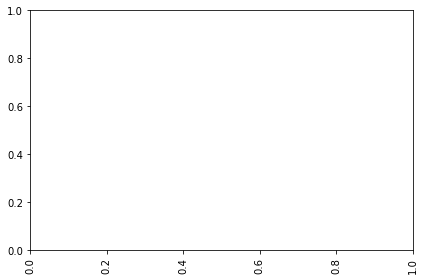

In [26]:
for i in range(len(model_feat_list)):
    if clf.coef_[0][i] > 0:
        print(model_feat_list[i])
        print(clf.coef_[0][i])
        print()
        plt.bar(model_feat_list[i], clf.coef_[0][i])
legend_elements = []
all_survey_keys = [k for k in scoring_guide["questions"].keys()
                   if "map_to" not in scoring_guide["questions"][k]] + scoring_guide["category_list"]
for i, f in enumerate(model_feat_list):
    if clf.coef_[0][i] > 0:
        if f in PASSIVE_FEATS:
            col = passive_color
        elif f in OTHER_GLOBAL_FEATS:
            col = global_other_color
        elif f in OTHER_LOCAL_FEATS:
            col = local_other_color
        elif f in all_survey_keys:
            if len(scoring_guide["category_list"]) > len(survey_colors):
                col = survey_colors[0]
            else:
                if f in scoring_guide["category_list"]:
                    col = survey_colors[scoring_guide["category_list"].index(f)]
                else:
                    group = scoring_guide["questions"][f]["category"]
                    col = survey_colors[scoring_guide["category_list"].index(group)]
        else:
            print(f)
        plt.bar(model_feat_list[i], clf.coef_[0][i], color=col)

plt.xticks(rotation=90)
lgd = fig.legend(handles=legend_elements, bbox_to_anchor=(1.5, -0.05), prop={'size': 10})
plt.tight_layout()